# PLUME VELOCITY

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
import scipy.io

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must i nclude .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
from cmcrameri import cm



In [2]:
# Define constants
tw = 308
yw = -0.015


def get_time(data_file):
    try:
        return float(data_file.split(".")[0].split("-")[-1])  #My directories
        #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    except:    
        return float(data_file.split(".")[1].split("-")[-1])


# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_T(node_x, node_y, data_file):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """

    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        #U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        #V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]

        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

        
        return flowtime, timestep, T

  


In [8]:

from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning


Trs = [1.8,] 
    #1.9, ]
    #2.3, 2.5, 2.9, 3.5, 4.0]
data_folders = [
    "/Volumes/ThermalAmp/Tr1.8/", 
    #"/Volumes/ThermalAmp/Tr1.9/",] 
    #"/Volumes/ThermalAmp/Tr2.3/", 
    #"/Volumes/ThermalAmp/Tr2.5/", 
    #"/Volumes/ThermalAmp/Tr2.9/",
    #"/Volumes/ThermalAmp/Tr3.5/", 
    #"/Volumes/ThermalAmp/Tr=4/"
]


for i, data_folder in enumerate(data_folders):

    case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    case_files = [f for f in case_files if "/._" not in f]
    
    fname = os.path.join(data_folder, case_files[0])
    
    # Read the mesh data from the HDF5 file
    with h5py.File(fname, 'r') as f:
        vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        wallcoords = np.transpose(f['/meshes/1.post/nodes/coords/2'][:])
    
    # Extract NodeX and NodeY
    node_x = vertex_list[0]
    node_y = vertex_list[1]
    WallX = wallcoords[0]
    WallY = wallcoords[1]
        
    data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
    data_files = [f for f in data_files if "/._" not in f]
    
    data_files = sorted(data_files, key=get_time)
    print(len(data_files))

    if "10000.dat.post" in data_files[3999]:
        # Use LokyBackend tso protect the h5py routine
        all_T = Parallel(n_jobs=-1, backend='threading', verbose=1) \
        (delayed(get_T) \
         (node_x, node_y, data_file
         ) for data_file in data_files[3999:-1001])
    else:
        # Use LokyBackend tso protect the h5py routine
        all_T = Parallel(n_jobs=-1, backend='threading', verbose=1) \
        (delayed(get_T) \
         (node_x, node_y, data_file
         ) for data_file in data_files[0:10000])
    
    all_T = np.array(all_T, dtype=object)
    Ts = all_T[:,2]
    
    T = np.vstack(Ts)
    
    # Check for DataInterpolant existence and create if not present
    DataInterpolant = NearestNDInterpolator(np.column_stack((node_x, node_y)), np.arange(len(node_x)))
    
    D = 0.01  
    L = (max(WallX) - min(WallX))
    Ybot = round(np.mean(WallY),3)
    
    FlowTime = all_T[:,0].astype(float) 
    
    # Interpolation grid
    x = np.linspace(-L/2, L/2, 512 + 1)
    y = Ybot + D/2* np.ones_like(x)
    
    # Get nearest indices
    NearestIndices = DataInterpolant(x, y)
    
    # Calculate Ti
    pixels = np.arange(0, 512 + 1)
    Ti = (T[:, NearestIndices.astype(int)] - 298) / (308 - 298)
    with h5py.File('/Volumes/ThermalAmp/Convvel/Ti_{}.h5'.format(Trs[i]), 'w') as hf:
        hf.create_dataset('Ti', data=Ti, compression='gzip', compression_opts=9)

    del Ti, T, Ts, all_T

env: PYTHONWARNINGS=ignore::UserWarning
10000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 10000 out of

In [9]:
# Check for DataInterpolant existence and create if not present
DataInterpolant = NearestNDInterpolator(np.column_stack((node_x, node_y)), np.arange(len(node_x)))

D = 0.01  
L = (max(WallX) - min(WallX))
Ybot = round(np.mean(WallY),3)

FlowTime = all_T[:,0].astype(float) 

# Interpolation grid
x = np.linspace(-L/2, L/2, 512 + 1)
y = Ybot + D/2* np.ones_like(x)

# Get nearest indices
NearestIndices = DataInterpolant(x, y)

# Calculate Ti
pixels = np.arange(0, 512 + 1)
Ti = (T[:, NearestIndices.astype(int)] - 298) / (308 - 298)

# Assuming x_pixels is your current x-axis in pixels
x_pixels = np.linspace(0, 512, 512 + 1)

# Define the desired range
x_min = -0.2
x_max = 0.2

# Map pixel positions to the new range
x_mapped = (x_min + (x_max - x_min) * (x_pixels / max(x_pixels)))/D

# Assuming Ti is your temperature data and FlowTime is your time data
# Plotting with the new x-axis
fig, ax = plt.subplots(figsize=(20, 10))  # Adjust the figsize to better fit your data
extent = [x_mapped[0], x_mapped[-1], FlowTime[0], FlowTime[-1]]

# Plotting the data
cax = ax.imshow(Ti, extent=extent, aspect='auto', origin='lower', cmap=cm.lajolla)

# Adjust axis labels and title
ax.set_xlabel('$x/D$', fontsize=14)
ax.set_ylabel('$Flow time$, (s)', fontsize=14)
ax.set_ylim([500, 600])
plt.tick_params(axis='both', which='major', labelsize=12) 

cb = plt.colorbar(cax, shrink=0.3, extend='max', label="$T_R$")
tick_locations = np.arange(0.05, 0.86,0.2)
cb.set_ticks(tick_locations)

# Set aspect ratio
ax.set_aspect((x_max - x_min) / (0.4))  # Adjust this to match your desired aspect ratio

#plt.savefig("/Volumes/ThermalAmp/PLOTS/convelTr{}.pdf".format(Tr), dpi=500, bbox_inches='tight')
# More plots as needed...
plt.show()

NameError: name 'all_T' is not defined

In [8]:
with h5py.File('/Volumes/ThermalAmp/Convvel/Ti_{}.h5'.format(Tr), 'w') as hf:
    hf.create_dataset('Ti', data=Ti, compression='gzip', compression_opts=9)


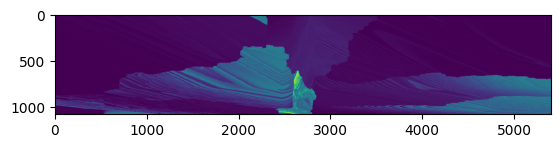

In [45]:
with h5py.File('/Volumes/ThermalAmp/Convvel/Ti_1.h5', 'r') as hf:
    # Access the dataset
    Ti1 = hf['Ti'][:]
with h5py.File('/Volumes/ThermalAmp/AverageContours/Temp/Tr2.3.h5', 'r') as hf:
    # Access the dataset
    Tinc = hf['T'][:]
plt.imshow(Tinc)

In [ ]:

case_files = ["/Volumes/ThermalAmp/Tr2.3/"+f for f in os.listdir("/Volumes/ThermalAmp/Tr2.3/") if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join("/Volumes/ThermalAmp/Tr2.3/", case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
    wallcoords = np.transpose(f['/meshes/1.post/nodes/coords/2'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

with h5py.File("/Volumes/ThermalAmp/Tr2.3/M4-10068.dat.post", 'r') as f:
    T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]

from scipy.interpolate import griddata
SI = griddata((node_x, node_y), T, (xgrid, ygrid), method='nearest', fill_value=np.nan)
plt.imshow(SI)


In [24]:
axes

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

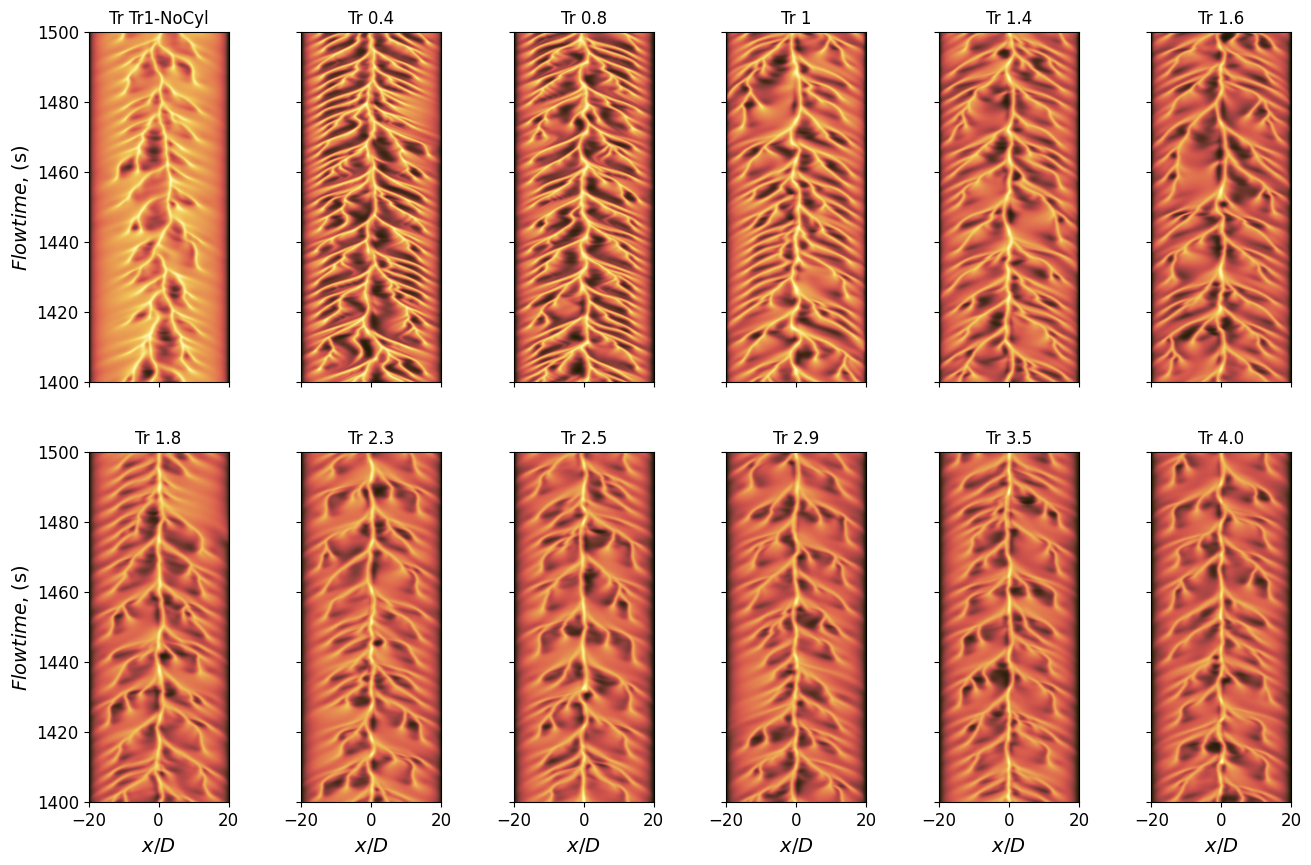

In [23]:


# Assuming x_pixels is your current x-axis in pixels
x_pixels = np.linspace(0, 512, 512 + 1)

# Define the desired range
x_min = -0.2
x_max = 0.2

# Map pixel positions to the new range
x_mapped = (x_min + (x_max - x_min) * (x_pixels / max(x_pixels)))/D


fig, axes = plt.subplots(2,6, figsize=(16, 10))  # Adjust the figsize to better fit your data
extent = [x_mapped[0], x_mapped[-1], FlowTime[0], FlowTime[-1]]

nrows, ncols = 2, 6
reordered_axes = [axes[r, c] for c in range(ncols) for r in range(nrows)]


Trs = ['Tr1-NoCyl', 0.4, 0.8, 1, 1.4, 1.6, 1.8, 2.3, 2.5, 2.9, 3.5, 4.0]

yposs = np.arange(0.005, -0.1, -0.05)
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
for i, ax in enumerate(axes):

    with h5py.File('/Volumes/ThermalAmp/Convvel/Ti_{}.h5'.format(Trs[i]), 'r') as hf:
        # Access the dataset
        Tinc = hf['Ti'][:]
    cax = ax.imshow(Tinc, extent=extent, aspect='auto', origin='lower', cmap=cm.lajolla)
    
    ax.set_ylim([1400, 1500])
    plt.tick_params(axis='both', which='major', labelsize=12) 
    ax.plot([0,10],[516,509], color='k')
    ax.plot([0,10],[516+12,509+12], color='k')
    ax.plot([0,10],[516+21,509+21], color='k')
    ax.tick_params(axis='both', which='major', labelsize=12) 

    ax.set_aspect((x_max - x_min) / (0.4))  # Adjust this to match your desired aspect ratio
    ax.set_title("Tr {}".format(Trs[i]))

    if i < 6:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('$x/D$', fontsize=14)
    if i % 6 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('$Flow time$, (s)', fontsize=14)
        
        
#cax = axes[1].imshow(Ti1, extent=extent, aspect='auto', origin='lower', cmap=cm.lajolla)
#axes[1].set_xlabel('$x/D$', fontsize=14)
#axes[1].set_yticklabels([])
#axes[1].set_ylim([1400, 1500])
#axes[1].plot([0,10],[516+20,509+19], color='k')


plt.tick_params(axis='both', which='major', labelsize=12) 

#cb_ax = fig.add_axes([0.95, 0.35, 0.02, 0.3])
#cb = plt.colorbar(cax, cax=cb_ax, shrink=0.3, extend='max', label="$T_R$", orientation='vertical', )
#tick_locations = np.arange(0.05, 0.86,0.2)
#cb.set_ticks(tick_locations)

# Set aspect ratio
#axes[0].set_aspect((x_max - x_min) / (0.4))  # Adjust this to match your desired aspect ratio
#axes[1].set_aspect((x_max - x_min) / (0.4))  # Adjust this to match your desired aspect ratio

#plt.savefig("/Volumes/ThermalAmp/PLOTS/NoCyl-and-cyl-convvel.pdf", dpi=600, bbox_inches='tight')

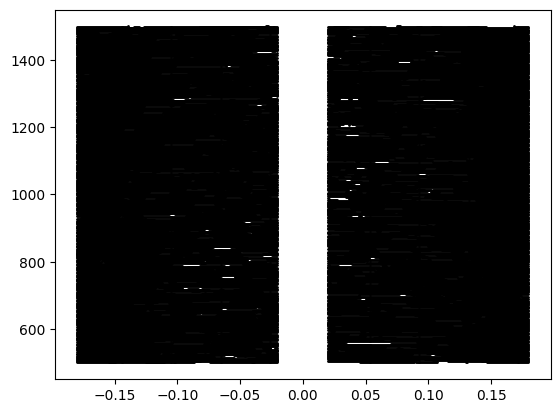

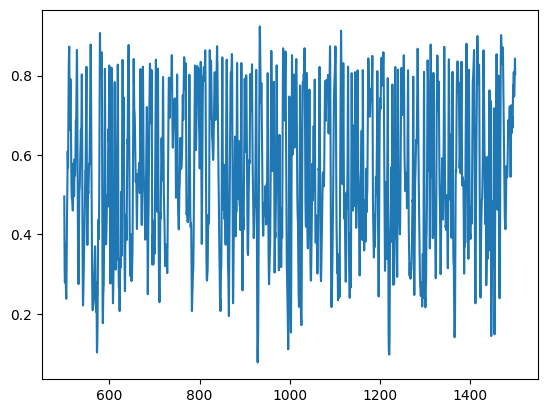

In [45]:

# Uncomment the following sections as needed to implement additional functionality
# Find local maxima (you may need to adjust this to fit your exact need)
#TF = (Ti[1:] > Ti[:-1]) & (Ti[1:] > Ti[2:])  # Example for local maxima

TF = np.zeros_like(Ti, dtype=bool)  # Initialize TF with the same shape as Ti

# Use a loop to find local maxima for each column
for col in range(Ti.shape[1]):
    # For each column, find local maxima using the difference method
    TF[1:-1, col] = (Ti[1:-1, col] > Ti[:-2, col]) & (Ti[1:-1, col] > Ti[2:, col])
    
TF[:, (np.abs(x/D) < 2) | (np.abs(x/D) > 18)] = False

#TimeScale calculations (if applicable)
TimeScale = np.empty(TF.shape[1])
for ii in range(TF.shape[1]):
    t_ = FlowTime[TF[:, ii]]
    if t_.size > 0:
        TimeScale[ii] = np.mean(np.diff(t_))  # Using mean instead of trimmean for simplicity

# Find indices for plotting local maxima
ix, iy = np.where(TF)
plt.plot(x[iy], FlowTime[ix], '.', color='k', markersize=2)

# Example for plotting temperature evolution
i_ = np.random.randint(Ti.shape[1])
plt.figure()
plt.plot(FlowTime, Ti[:, i_])
plt.plot(FlowTime[TF[:, i_]], Ti[TF[:, i_], i_], 'ok')

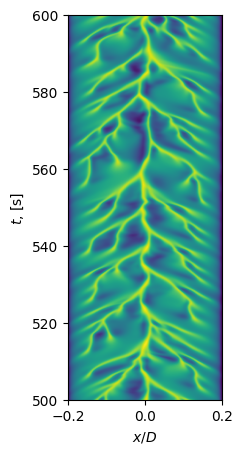

In [102]:
# Assuming x_pixels is your current x-axis in pixels
x_pixels = np.linspace(0, 512, 512 + 1)

# Define the desired range
x_min = -0.2
x_max = 0.2

# Map pixel positions to the new range
x_mapped = x_min + (x_max - x_min) * (x_pixels / max(x_pixels))

# Assuming Ti is your temperature data and FlowTime is your time data
# Plotting with the new x-axis
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figsize to better fit your data
extent = [x_mapped[0], x_mapped[-1], FlowTime[0], FlowTime[-1]]

# Plotting the data
cax = ax.imshow(Ti, extent=extent, aspect='auto', origin='lower', cmap='viridis')

# Adjust axis labels and title
ax.set_xlabel('$x/D$')
ax.set_ylabel('$t$, [s]')
ax.set_ylim([500, 600])

# Set aspect ratio
ax.set_aspect((x_max - x_min) / (40))  # Adjust this to match your desired aspect ratio


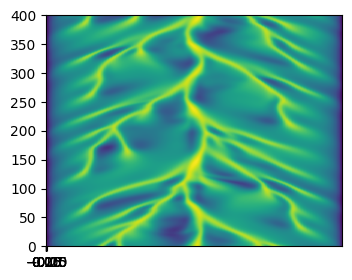

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.imshow(Ti)
ax.set_ylim(0,400)
x_ticks = np.arange(-0.2, 0.201, 0.05)
ax.set_xticks(x_ticks)

In [82]:
T[:, NearestIndices.astype(int)]

array([[298.6154214 , 298.87431562, 299.17111546, ..., 299.21197418,
        298.9056974 , 298.6372424 ],
       [298.6143048 , 298.87297484, 299.1696133 , ..., 299.21148141,
        298.90523144, 298.63690212],
       [298.61309983, 298.87153166, 299.16799666, ..., 299.21088498,
        298.9047033 , 298.63652744],
       ...,
       [298.66001165, 298.94410603, 299.26542086, ..., 299.18592715,
        298.8850713 , 298.62229417],
       [298.66159465, 298.94618563, 299.26822826, ..., 299.18508385,
        298.88443759, 298.62185454],
       [298.66283044, 298.94780469, 299.27047031, ..., 299.18428114,
        298.88383402, 298.62143513]])

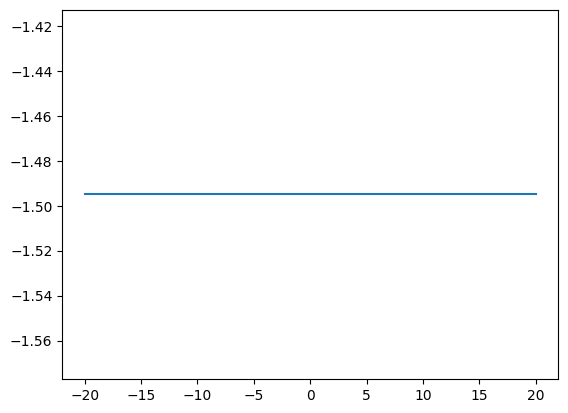

In [102]:
plt.plot(x,y)

In [103]:
y

array([-1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
       -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495, -1.495,
      

In [64]:
Ybot

np.float64(-1.5)